In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

plt.style.use("seaborn")

2024-12-10 19:36:14.570369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 19:36:14.591249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 19:36:14.597449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 19:36:14.613286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/tmp/ipykernel_215844/3292972437.py:17: M

In [2]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
DATASET_DIR = "Real Life Violence Dataset"
CLASSES_LIST = ["NonViolence", "Violence"]

In [3]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [4]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths


In [5]:
features, labels, video_files_paths = create_dataset()
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Extracting Data of Class: NonViolence


[h264 @ 0x55b60a3675c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x55b60a3675c0] error while decoding MB 98 31
[h264 @ 0x55b623f70780] mb_type 104 in P slice too large at 98 31
[h264 @ 0x55b623f70780] error while decoding MB 98 31
[h264 @ 0x55b623f70780] mb_type 104 in P slice too large at 98 31
[h264 @ 0x55b623f70780] error while decoding MB 98 31
[h264 @ 0x55b623f70780] mb_type 104 in P slice too large at 98 31
[h264 @ 0x55b623f70780] error while decoding MB 98 31
[h264 @ 0x55b623f70780] mb_type 104 in P slice too large at 98 31
[h264 @ 0x55b623f70780] error while decoding MB 98 31


Extracting Data of Class: Violence
Features shape: (2000, 16, 64, 64, 3)
Labels shape: (2000,)


In [6]:
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

In [7]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    one_hot_encoded_labels, 
    test_size=0.1,
    shuffle=True, 
    random_state=42
)

print("Training set shape:", features_train.shape, labels_train.shape)
print("Testing set shape:", features_test.shape, labels_test.shape)

Training set shape: (1800, 16, 64, 64, 3) (1800, 2)
Testing set shape: (200, 16, 64, 64, 3) (200, 2)


In [8]:
def create_model():
    model = Sequential()
    
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    mobilenet = MobileNetV2(include_top=False, weights="imagenet")
    mobilenet.trainable = True
    
    for layer in mobilenet.layers[:-40]:
        layer.trainable = False
    
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))
    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    
    return model

In [9]:
model = create_model()
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

/var/tmp/ipykernel_215844/2649550708.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights="imagenet")
I0000 00:00:1733859894.669074  215844 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733859894.679740  215844 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733859894.682984  215844 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), bu

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 2, 2, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 2, 2, 1280) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 5120)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │     1,319,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,637,090 (13.87 MB)

 Trainable params: 3,060,642 (11.68 MB)

 Non-trainable params: 576,448 (2.20 MB)

In [11]:
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=5,
    min_lr=0.00005,
    verbose=1
)

history = model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/50


2024-12-10 19:46:09.682868: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904
W0000 00:00:1733859969.768924  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859969.791165  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859969.792342  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859969.815101  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859969.816205  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859969.817335  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859969.820316  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859969.821481  249229 gpu_t

  1/360 ━━━━━━━━━━━━━━━━━━━━ 7:15:19 73s/step - accuracy: 0.5000 - loss: 0.5985 - precision: 0.5000 - recall: 0.5000

W0000 00:00:1733859971.927654  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.929134  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.929972  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.932864  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.933576  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.934285  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.935011  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.935758  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733859971.937394  249229 gp

360/360 ━━━━━━━━━━━━━━━━━━━━ 133s 168ms/step - accuracy: 0.5096 - loss: 0.7027 - precision: 0.5096 - recall: 0.5096 - val_accuracy: 0.5944 - val_loss: 0.6834 - val_precision: 0.5944 - val_recall: 0.5944 - learning_rate: 0.0100
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.5470 - loss: 0.6868 - precision: 0.5470 - recall: 0.5470 - val_accuracy: 0.7028 - val_loss: 0.6280 - val_precision: 0.7028 - val_recall: 0.7028 - learning_rate: 0.0100
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 124ms/step - accuracy: 0.6824 - loss: 0.6293 - precision: 0.6824 - recall: 0.6824 - val_accuracy: 0.7667 - val_loss: 0.5065 - val_precision: 0.7667 - val_recall: 0.7667 - learning_rate: 0.0100
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.7274 - loss: 0.5486 - precision: 0.7274 - recall: 0.7274 - val_accuracy: 0.8139 - val_loss: 0.4337 - val_precision: 0.8139 - val_recall: 0.8139 - learning_rate: 0.0100
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accur

In [12]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(features_test, labels_test)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

W0000 00:00:1733861322.836549  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.838008  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.839352  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.840595  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.841896  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.843210  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.844514  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.845822  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861322.847091  249222 gp

1/7 ━━━━━━━━━━━━━━━━━━━━ 1:33 16s/step - accuracy: 0.9062 - loss: 0.2234 - precision: 0.9062 - recall: 0.9062

W0000 00:00:1733861323.242236  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.242974  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.243687  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.244401  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.245132  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.245881  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.246631  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.247349  249229 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.248216  249229 gp

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9043 - loss: 0.2534 - precision: 0.9043 - recall: 0.9043

W0000 00:00:1733861323.931555  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.932295  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.932999  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.933694  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.934383  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.935092  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.935789  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.936494  249222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733861323.937205  249222 gp

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.9008 - loss: 0.2683 - precision: 0.9008 - recall: 0.9008
Test Loss: 0.3130
Test Accuracy: 0.8900
Test Precision: 0.8900
Test Recall: 0.8900
F1 Score: 0.8900


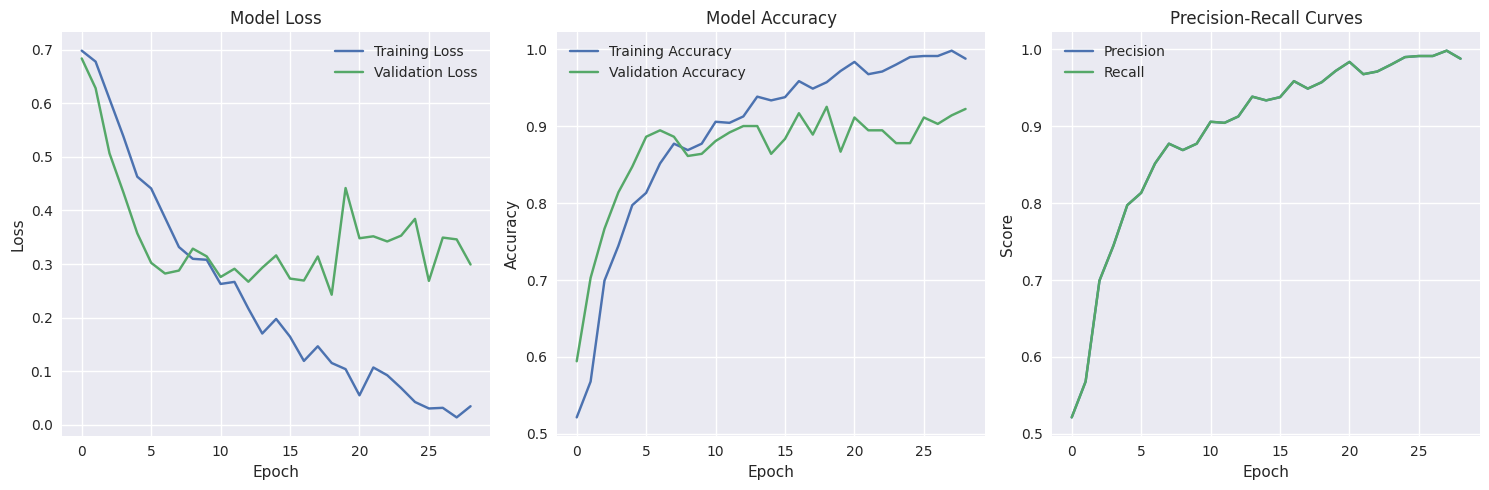

In [13]:
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision-Recall Plot
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.title('Precision-Recall Curves')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def predict_video(video_file_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_file_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    if len(frames_list) == SEQUENCE_LENGTH:
        predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis=0))[0]
        predicted_label = np.argmax(predicted_labels_probabilities)
        predicted_class_name = CLASSES_LIST[predicted_label]
        
        print(f'Prediction: {predicted_class_name}')
        print(f'Confidence: {predicted_labels_probabilities[predicted_label]}')
        return predicted_class_name, predicted_labels_probabilities[predicted_label]
    
    return None, None